In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('/Users/oeyvind/Documents/Sporck.no/BCO_USD_D.csv')
df.head()

,Date,Volume,Open,High,Low,Close
0,2003-08-18 21:00:00+00:00,570,29.457,29.669,28.926,29.254
1,2003-08-19 21:00:00+00:00,602,29.201,29.681,28.980,29.583
2,2003-08-20 21:00:00+00:00,752,29.572,30.892,29.569,30.450
3,2003-08-21 21:00:00+00:00,496,30.302,30.617,30.261,30.391
4,2003-08-25 21:00:00+00:00,542,30.001,30.431,30.001,30.370


In [18]:
def plot_results(agent, dataset, print_line = 5):
    close = dataset.Close.values.tolist()
    states_buy, states_sell, total_gains, invest, states_money = agent.kjøp(close, start_penger = 10000, print_line = print_line)

    fig = plt.figure(figsize = (15,5))
    
    plt.plot(close, color='r', lw=2.)
    plt.plot(close, '^', markersize=10, color='m', label = 'kjøpssignal', markevery = states_buy)
    plt.plot(close, 'v', markersize=10, color='k', label = 'salgssignal', markevery = states_sell)
    plt.title('Investeringstriggere')
    plt.legend()
    plt.show()
    
    fig = plt.figure(figsize = (15,5))
    plt.plot(states_money, color='r', lw=2.)
    plt.plot(states_money, '^', markersize=10, color='m', label = 'kjøpssignal', markevery = states_buy)
    plt.plot(states_money, 'v', markersize=10, color='k', label = 'salgssignal', markevery = states_sell)
    plt.title('Vi satset USD 10 000 \n Total avkastning %f USD ( %f%% )'%(total_gains, invest))
    plt.legend()
    plt.show()

In [19]:
class PolicyGradientAgent:

    læringsrate = 1e-4
    AntallLag = 256
    Gamma = 0.4
    StørrelseUt = 5

    def __init__(self, state_size, vindu, trend, skip):
        tf.compat.v1.disable_eager_execution()
        self.state_size = state_size
        self.vindu = vindu
        self.halvt_vindu = vindu // 2
        self.trend = trend
        self.skip = skip
        self.X = tf.compat.v1.placeholder(tf.float32, (None, self.state_size))
        self.Belønning = tf.compat.v1.placeholder(tf.float32, (None))
        self.Handling = tf.compat.v1.placeholder(tf.int32, (None))
        feed_forward = tf.compat.v1.layers.dense(self.X, self.AntallLag, activation = tf.nn.relu)
        self.logits = tf.compat.v1.layers.dense(feed_forward, self.StørrelseUt, activation = tf.nn.softmax)
        input_y = tf.one_hot(self.Handling, self.StørrelseUt)
        loglike = tf.math.log((input_y * (input_y - self.logits) + (1 - input_y) * (input_y + self.logits)) + 1)
        rewards = tf.tile(tf.reshape(self.Belønning, (-1,1)), [1, self.StørrelseUt])
        self.cost = -tf.reduce_mean(input_tensor=loglike * (rewards + 1)) 
        self.optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate = self.læringsrate).minimize(self.cost)
        self.sess = tf.compat.v1.InteractiveSession()
        self.sess.run(tf.compat.v1.global_variables_initializer())
    
    def predict(self, inputs):
        return self.sess.run(self.logits, feed_dict={self.X:inputs})
    
    def get_state(self, t):
        vindu = self.vindu + 1
        d = t - vindu + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(vindu - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])
    
    def kjøp(self, close, start_penger, print_line):
        opprinnelig_sum = start_penger
        states_selg = []
        states_kjøp = []
        states_penger = []
        beholdning = []
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.get_predicted_action(state)
            next_state = self.get_state(t + 1)
            
            if action == 1 and start_penger >= self.trend[t] and t < (len(self.trend) - self.halvt_vindu):
                beholdning.append(self.trend[t])
                start_penger -= self.trend[t]
                states_kjøp.append(t)
                if t % print_line == 0:
                    print('Dag %d: kjøpte en enhet for %f.'% (t, self.trend[t]))
                
                
            elif action == 2 and len(beholdning):
                pris_kjøpt = beholdning.pop(0)
                start_penger += self.trend[t]
                states_selg.append(t)
                try:
                    invest = ((close[t] - pris_kjøpt) / pris_kjøpt) * 100
                except:
                    invest = 0
                if t % print_line == 0:
                    print(
                    'Dag %d: solgte en enhet for %f.'
                    % (t, close[t])
                    )
            
            state = next_state
            states_penger.append(start_penger)
        invest = ((start_penger - opprinnelig_sum) / opprinnelig_sum) * 100
        fortjeneste = start_penger - opprinnelig_sum
        return states_kjøp, states_selg, fortjeneste, invest, states_penger
    
    def discount_rewards(self, r):
        discounted_r = np.zeros_like(r)
        running_add = 0
        for t in reversed(range(0, r.size)):
            running_add = running_add * self.Gamma + r[t]
            discounted_r[t] = running_add
        return discounted_r
    
    def get_predicted_action(self, sequence):
        prediction = self.predict(np.array(sequence))[0]
        return np.argmax(prediction)
            
    def train(self, iterations, checkpoint, start_penger, close):
        for i in range(iterations):
            ep_history = []
            total_profit = 0
            beholdning = []
            state = self.get_state(0)
            opprinnelig_sum = start_penger
            for t in range(0, len(self.trend) - 1, self.skip):
                action = self.get_predicted_action(state)
                next_state = self.get_state(t + 1)
                if action == 1 and opprinnelig_sum >= self.trend[t] and t < (len(self.trend) - self.halvt_vindu):
                    beholdning.append(self.trend[t])
                    opprinnelig_sum -= close[t]
                
                elif action == 2 and len(beholdning):
                    pris_kjøpt = beholdning.pop(0)
                    total_profit += self.trend[t] - pris_kjøpt
                    opprinnelig_sum += self.trend[t]
                ep_history.append([state,action,opprinnelig_sum,next_state])
                state = next_state
            ep_history = np.array(ep_history)
            ep_history[:,2] = self.discount_rewards(ep_history[:,2])
            cost, _ = self.sess.run([self.cost, self.optimizer], feed_dict={self.X:np.vstack(ep_history[:,0]),
                                                    self.Belønning:ep_history[:,2],
                                                    self.Handling:ep_history[:,1]})
            if (i+1) % checkpoint == 0:
                print('Runde: %d, total belønning: %f.3, kostnad: %f, portefølje: %f'%(i + 1, total_profit, cost,
                                                                                  opprinnelig_sum))

In [20]:
def PolicyGradient(dataset, vindu = 30, skip = 1, iterations = 200, checkpoint = 20, print_line = 5):
    close = dataset.Close.values.tolist()
    PolicyAgent = PolicyGradientAgent(state_size = vindu,
             vindu = vindu,
             trend = close,
             skip = skip)
    PolicyAgent.train(iterations = iterations, checkpoint = checkpoint, start_penger = 10000, close=close)
    print('\n')
    plot_results(PolicyAgent, dataset, print_line = print_line)

Runde: 20, total belønning: 9.590000.3, kostnad: -3355.399902, portefølje: 7691.061000
Runde: 40, total belønning: -36.880000.3, kostnad: -3690.568848, portefølje: 9276.017000
Runde: 60, total belønning: 1.308000.3, kostnad: -4007.757568, portefølje: 10001.308000
Runde: 80, total belønning: 39.904000.3, kostnad: -4024.613281, portefølje: 9547.632000
Runde: 100, total belønning: 94.542000.3, kostnad: -4076.865967, portefølje: 9883.488000
Runde: 120, total belønning: 25.103000.3, kostnad: -4064.024414, portefølje: 9743.808000
Runde: 140, total belønning: 13.660000.3, kostnad: -4069.775635, portefølje: 9872.441000
Runde: 160, total belønning: 73.696000.3, kostnad: -4051.570312, portefølje: 9863.527000
Runde: 180, total belønning: 117.656000.3, kostnad: -4012.021973, portefølje: 9767.587000
Runde: 200, total belønning: 53.730000.3, kostnad: -4214.098145, portefølje: 10053.730000


Dag 5: solgte en enhet for 65.375000.
Dag 30: solgte en enhet for 62.405000.
Dag 35: solgte en enhet for 59.16

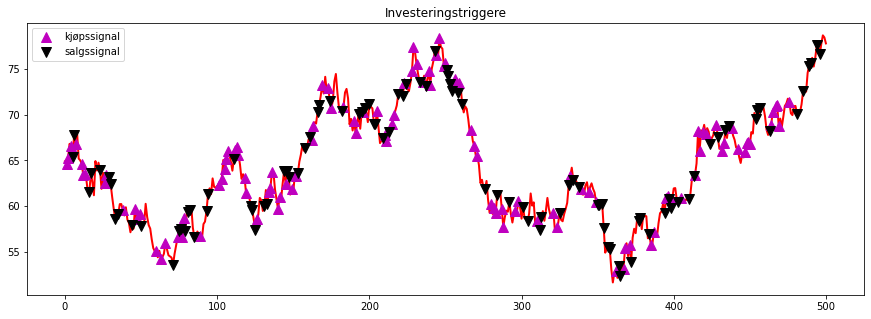

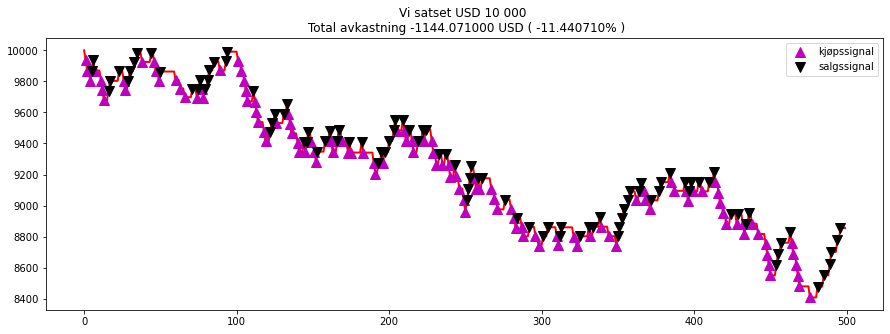

In [21]:
# Run the Policy Gradient agent with the subset of daily prices
PolicyGradient(df.loc[500:1000])